# Mark and Recapture

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
# Get utils.py

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py

This chapter introduces "mark and recapture" experiments, in which we sample individuals from a population, mark them somehow, and then take a second sample from the same population.  Seeing how many individuals in the second sample are marked, we can estimate the size of the population.

Experiments like this were originally used in ecology, but turn out to be useful in many other fields.  Examples in this chapter include software engineering and epidemiology.

Also, in this chapter we'll work with models that have three parameters, so we'll extend the joint distributions we've been using to three dimensions.

But first, grizzly bears.

## The Grizzly Bear Problem

In 1996 and 1997 researchers deployed bear traps in locations in British Columbia and Alberta, Canada, in an effort to estimate the population of grizzly bears.  They describe the experiment in "[Estimating Population Size of Grizzly Bears Using Hair Capture, DNA Profiling, and Mark-Recapture Analysis](https://www.researchgate.net/publication/229195465_Estimating_Population_Size_of_Grizzly_Bears_Using_Hair_Capture_DNA_Profiling_and_Mark-Recapture_Analysis)".

The "trap" consists of  a lure and several strands of barbed wire intended to capture samples of hair from bears that visit the lure.  Using the hair samples, the researchers use DNA analysis to identify individual bears.

During the first session, the researchers deployed traps at 76 sites.  Returning 10 days later, they obtained 1043 hair samples and identified 23 different bears.  During a second 10-day session they obtained 1191 samples from 19 different bears, where 4 of the 19 were from bears they had identified in the first batch.

To estimate the population of bears from this data, we need a model for the probability that each bear will be observed during each session.  As a starting place, we'll make the simplest assumption, that every bear in the population has the same (unknown) probability of being sampled during each session.

With these assumptions we can compute the probability of the data for a range of possible populations.

As an example, let's suppose that the actual population of bears is 100.

After the first session, 23 of the 100 bears have been identified.
During the second session, if we choose 19 bears at random, what is the probability that 4 of them were previously identified?

I'll define

* $N$: actual population size, 100.

* $K$: number of bears identified in the first session, 23.

* $n$: number of bears observed in the second session, 19 in the example.

* $k$: the number of bears in the second session that had previously been identified, 4.

For given values of $N$, $K$, and $n$, the probability of finding $k$ previously-identified bears is given by the [hypergeometric distribution](https://en.wikipedia.org/wiki/Hypergeometric_distribution):

$${K \choose k}{N-K \choose n-k}/{N \choose n}$$

where the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient), ${K \choose k}$, is the number of subsets of size $k$ we can choose from a population of size $K$.

To understand why, consider: 

* The denominator, ${ N \choose n}$, is the number of subsets of $n$ we could choose from a population of $N$ bears.

* The numerator is the number of subsets that contain $k$ bears from the previously identified $K$ and $n-k$ from the previously unseen $N-K$.

SciPy provides `hypergeom`, which we can use to compute this probability for a range of values of $k$.

In [3]:
import numpy as np
from scipy.stats import hypergeom

N = 100
K = 23
n = 19

ks = np.arange(12)
ps = hypergeom(N, K, n).pmf(ks)

The result is the distribution of $k$ with given parameters $N$, $K$, and $n$.
Here's what it looks like.

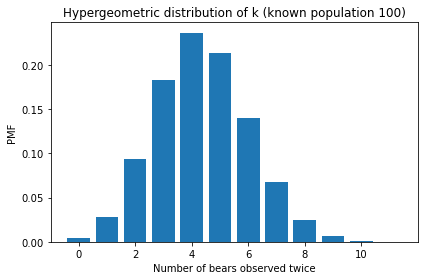

In [4]:
import matplotlib.pyplot as plt
from utils import decorate

plt.bar(ks, ps)

decorate(xlabel='Number of bears observed twice',
         ylabel='PMF',
         title='Hypergeometric distribution of k (known population 100)')

The most likely value of $k$ is 4, which is the value actually observed in the experiment.  
That suggests that $N=100$ is a reasonable estimate of the population, given this data.

We've computed the distribution of $k$ given $N$, $K$, and $n$.
Now let's go the other way: given $K$, $n$, and $k$, how can we estimate the total population, $N$?

## The Update

As a starting place, let's suppose that, prior to this study, an expert estimates that the local bear population is between 50 and 500, and equally likely to be any value in that range.

In [5]:
from empiricaldist import Pmf

def discrete_uniform(start, stop, step=1, name=None, **options):
    """Make a Pmf that represents a uniform distribution.
    
    start: lower bound
    stop: upper bound
    step: step size between values
    name: string name for the quantities
    options: passed to Pmf
    
    returns: Pmf
    """
    qs = np.arange(start, stop, step)
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [6]:
prior_N = discrete_uniform(50, 501, name='N')
prior_N.shape

(451,)

So that's our prior.

To compute the likelihood of the data, we can use `hypergeom` with constants `K` and `n`, and a range of values of `N`. 

In [7]:
Ns = prior_N.qs
K = 23
n = 19
k = 4

likelihood = hypergeom(Ns, K, n).pmf(k)

We can compute the posterior in the usual way.

In [8]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.07755224277106727

And here's what it looks like.

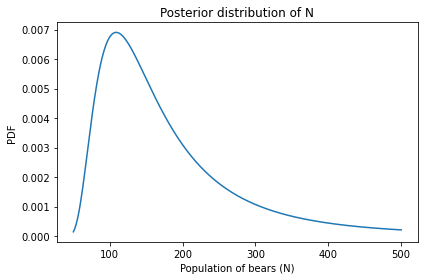

In [9]:
posterior_N.plot()

decorate(xlabel='Population of bears (N)',
         ylabel='PDF',
         title='Posterior distribution of N')

The most likely value is 109.

In [10]:
posterior_N.max_prob()

109

But the distribution is skewed to the right, so the posterior mean is substantially higher.

In [11]:
posterior_N.mean()

173.79880627085637

And the credible interval is quite wide.

In [12]:
posterior_N.credible_interval(0.9)

array([ 77., 363.])

This solution is relatively simple, but it turns out we can do a little better if we model the unknown probability of observing a bear explicitly.

## Two Parameter Model

Next we'll try a model with two parameters: the number of bears, `N`, and the probability of observing a bear, `p`.

We'll assume that the probability is the same in both rounds, which is probably reasonable in this case because it is the same kind of trap in the same place.

We'll also assume that the probabilities are independent; that is, the probability a bear is observed in the second round does not depend on whether it was observed in the first round.  This assumption might be less reasonable, but for now it is a necessary simplification.

Here are the counts again:

In [13]:
K = 23
n = 19
k = 4

For this model, I'll express the data in different notation: 

* `k10` is the number of bears observed in the first round but not the second,

* `k01` is the number of bears observed in the second round but not the first, and

* `k11` is the number of bears observed in both rounds.

Here are their values.

In [14]:
k10 = 23 - 4
k01 = 19 - 4
k11 = 4

Suppose we know the actual values of `N` and `p`.  We can use them to compute the likelihood of this data.

For example, suppose we know that `N=100` and `p=0.2`.

We can use `N` to compute `k00`, which is the number of unobserved bears.

In [15]:
N = 100

observed = k01 + k10 + k11
k00 = N - observed
k00

62

For the update, it will be convenient to store the data as a list that represents the number of bears in each category.

In [16]:
x = [k00, k01, k10, k11]
x

[62, 15, 19, 4]

Now, if we know `p=0.2`, we can compute the probability a bear falls in each category.  For example, the probability of being observed in both rounds is `p*p`, and the probability of being unobserved in both rounds is `q*q` (where `q=1-p`).

In [17]:
p = 0.2
q = 1-p
y = [q*q, q*p, p*q, p*p]
y

[0.6400000000000001,
 0.16000000000000003,
 0.16000000000000003,
 0.04000000000000001]

Now the probability of the data is given by the [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution):

$$\frac{N!}{\prod x_i!} \prod y_i^{x_i}$$

where $N$ is actual population, $x$ is a sequence with the counts in each category, and $y$ is a sequence of probabilities for each category.

SciPy provides `multinomial`, which provides `pmf`, which computes this probability.
Here is the probability of the data for these values of `N` and `p`.

In [18]:
from scipy.stats import multinomial

likelihood = multinomial.pmf(x, N, y)
likelihood

0.0016664011988507257

That's the likelihood if we know `N` and `p`, but of course we don't.  So we'll choose prior distributions for `N` and `p`, and use the likelihoods to update it. 

## The Prior

Here is a uniform prior for the number of bears, `N`:

In [19]:
prior_N = discrete_uniform(50, 501, name='N')
prior_N.head(3)

N
50    0.002217
51    0.002217
52    0.002217
dtype: float64

And a uniform prior for the probability of observing a bear, `p`:

In [20]:
from utils import make_uniform

prior_p = make_uniform(0, 0.99, num=100, name='p')
prior_p.head(3)

p
0.00    0.01
0.01    0.01
0.02    0.01
dtype: float64

We can make a joint distribution in the usual way.

In [21]:
from utils import make_joint

joint_prior = make_joint(prior_p, prior_N)
joint_prior.head(3)

p,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.90,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
N,,,,,,,,,,,,,,,,,,,,,
50,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
51,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022
52,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,...,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022,0.000022


The result is a Pandas `DataFrame` with values of `N` down the rows and values of `p` across the columns.
However, for this problem it will be convenient to represent the prior distribution as a 1-D `Series` rather than a 2-D `DataFrame`.
We can convert from one format to the other using `stack`.

In [22]:
joint_pmf = Pmf(joint_prior.stack())
joint_pmf.head(3)

N   p   
50  0.00    0.000022
    0.01    0.000022
    0.02    0.000022
dtype: float64

The result is a `Pmf` whose index is a `MultiIndex`.

In [23]:
type(joint_pmf)

empiricaldist.empiricaldist.Pmf

In [24]:
type(joint_pmf.index)

pandas.core.indexes.multi.MultiIndex

A `MultiIndex` can have more than one column; in this example, the first column contains values of `N` and the second column contains values of `p`.

The `Pmf` has one row (and one prior probability) for each possible pair of parameters `N` and `p`.
So the total number of rows is the product of the lengths of `prior_N` and `prior_p`.

In [25]:
joint_pmf.shape

(45100,)

Now we have to compute the likelihood of the data for each pair of parameters.

## The Update

To allocate space for the likelihoods, it is convenient to make a copy of `joint_pmf`:

In [26]:
likelihood = joint_pmf.copy()

As we loop through the pairs of parameters, we compute the likelihood of the data as in the previous section, and then store the result as an element of `likelihood`.

In [27]:
observed = k01 + k10 + k11

for N, p in joint_pmf.index:
    k00 = N - observed
    x = [k00, k01, k10, k11]
    q = 1-p
    y = [q*q, q*p, p*q, p*p]
    likelihood[N, p] = multinomial.pmf(x, N, y)

Now we can compute the posterior in the usual way.

In [28]:
posterior_pmf = joint_pmf * likelihood
posterior_pmf.normalize()

2.9678796190279657e-05

We can use `plot_contour` again to visualize the joint posterior distribution.

But remember that the posterior distribution we just computed is represented as a `Pmf`, which is a `Series`, and `plot_contour` expects a `DataFrame`.

Since we used `stack` to convert from a `DataFrame` to a `Series`, we can use `unstack` to go the other way.

In [29]:
joint_posterior = posterior_pmf.unstack()

And here's what the result looks like.

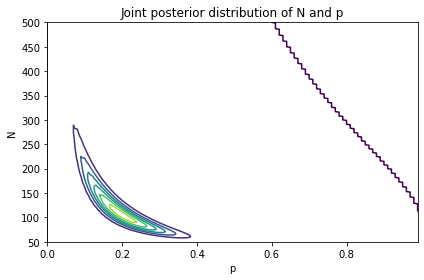

In [30]:
from utils import plot_contour

plot_contour(joint_posterior)

decorate(title='Joint posterior distribution of N and p')

The most likely values of `N` are near 100, as in the previous model. The most likely values of `p` are near 0.2.

The shape of this contour indicates that these parameters are correlated.  If `p` is near the low end of the range, the most likely values of `N` are higher; if `p` is near the high end of the range, `N` is lower. 

Now that we have a posterior `DataFrame`, we can extract the marginal distributions in the usual way.

In [31]:
from utils import marginal

posterior2_p = marginal(joint_posterior, 0)
posterior2_N = marginal(joint_posterior, 1)

Here's the posterior distribution for `p`:

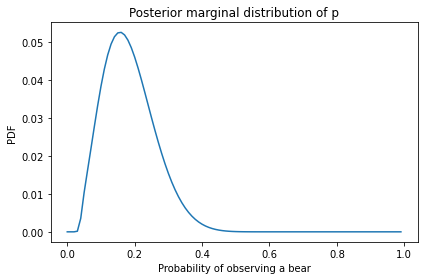

In [32]:
posterior2_p.plot()

decorate(xlabel='Probability of observing a bear',
         ylabel='PDF',
         title='Posterior marginal distribution of p')

The most likely values are near 0.2.

And here's the posterior distribution for `N`, along with the posterior we got using the hypergeometric distribution.

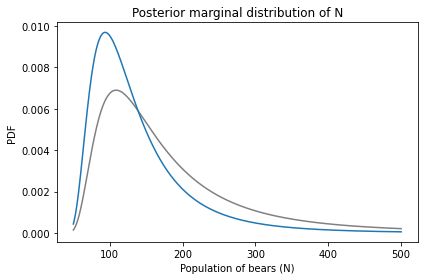

In [33]:
posterior_N.plot(color='gray')
posterior2_N.plot()

decorate(xlabel='Population of bears (N)',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

The mean is a little lower and the 90% credible interval is a little narrower.

In [34]:
posterior_N.mean(), posterior_N.credible_interval(0.9)

(173.79880627085637, array([ 77., 363.]))

In [35]:
posterior2_N.mean(), posterior2_N.credible_interval(0.9)

(138.750521364726, array([ 68., 277.]))

It might seem surprising that the second model, which has more parameters, yields a narrower posterior distribution of `N`.

That's possible if the two-parameter model is taking advantage of additional information somehow.
See if you can figure out what that information is, and I'll explain after the next section.

## Joint and marginal distributions

Marginal distributions are called "marginal" because in a common visualization they appear in the margins of the plot.

Seaborn provides a class called `JointGrid` that creates this visualization.
The following function uses it to show the joint and marginal distributions in a single plot.

In [36]:
import pandas as pd
from seaborn import JointGrid

def joint_plot(joint, **options):
    """Show joint and marginal distributions.
    
    joint: DataFrame that represents a joint distribution
    options: passed to JointGrid
    """
    # get the names of the parameters
    x = joint.columns.name
    x = 'x' if x is None else x

    y = joint.index.name
    y = 'y' if y is None else y

    # make a JointGrid with minimal data
    data = pd.DataFrame({x:[0], y:[0]})
    g = JointGrid(x=x, y=y, data=data, **options)

    # replace the contour plot
    g.ax_joint.contour(joint.columns, 
                       joint.index, 
                       joint, 
                       cmap='viridis')
    
    # replace the marginals
    marginal_x = marginal(joint, 0)
    g.ax_marg_x.plot(marginal_x.qs, marginal_x.ps)
    
    marginal_y = marginal(joint, 1)
    g.ax_marg_y.plot(marginal_y.ps, marginal_y.qs)

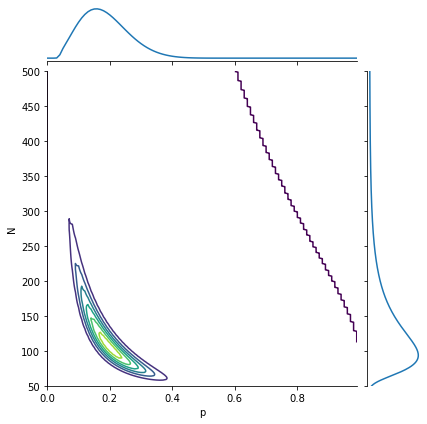

In [37]:
joint_plot(joint_posterior)

A `JointGrid` is a concise way to represent the joint and marginal distributions visually.

## Two Parameters Better Than One?

The two-parameter model yields a narrower posterior distribution for `N`, compared to the one-parameter model, because it takes advantage of an additional source of information: the number of bears observed during the two trials.
Specifically, it takes into account the consistency of the two observations.

To see how this helps, consider a scenario where `N` is relatively low, like 138 (the posterior mean of the two-parameter model).

In [38]:
N1 = 138

Given that we saw 23 bears during the first trial and 19 during the second, we can estimate the corresponding value of `p`.

In [39]:
mean = (23 + 19) / 2
p = mean/N1
p

0.15217391304347827

With these parameters, how much variability do you expect in the number of bears from one trial to the next?  We can quantify that by computing the standard deviation of the binomial distribution with these parameters.

In [40]:
from scipy.stats import binom

binom(N1, p).std()

4.219519857292647

Now let's consider a second scenario where `N` is 173, the posterior mean of the one-parameter model.  The corresponding value of `p` is lower.

In [41]:
N2 = 173
p = mean/N2
p

0.12138728323699421

In this scenario, the variation we expect to see from one trial to the next is higher.

In [42]:
binom(N2, p).std()

4.2954472470306415

So if the number of bears we observe is the same in both trials, that would be evidence for lower values of `N`, where we expect more consistency.

If the number of bears is substantially different between the two trials, that would be evidence for higher values of `N`.

In the actual data, the difference between the two trials is low, which is why the posterior mean of the two-parameter model is lower.

And the two-parameter model takes advantage of additional information, which is why the credible interval is narrower.

## The Lincoln index problem

In [an excellent blog post](http://www.johndcook.com/blog/2010/07/13/lincoln-index/), John D. Cook wrote about the Lincoln index, which is a way to estimate the
number of errors in a document (or program) by comparing results from
two independent testers. 

Here's his presentation of the problem:

>"Suppose you have a tester who finds 20 bugs in your program. You
want to estimate how many bugs are really in the program. You know
there are at least 20 bugs, and if you have supreme confidence in your
tester, you may suppose there are around 20 bugs. But maybe your
tester isn't very good. Maybe there are hundreds of bugs. How can you
have any idea how many bugs there are? There's no way to know with one
tester. But if you have two testers, you can get a good idea, even if
you don't know how skilled the testers are."

Suppose the first tester finds 20 bugs, the second finds 15, and they
find 3 in common; how can we estimate the number of bugs?

This problem is similar to the Grizzly Bear problem, so I'll represent the data in the same way.

In [95]:
k10 = 20 - 3
k01 = 15 - 3
k11 = 3

But in this case it is probably not reasonable to assume that the testers have the same probability of finding a bug.
So I'll define two parameters, `p0` for the probability that the first tester finds a bug, and `p1` for the probability that the second tester finds a bug.

I will continue to assume that the probabilities are independent, which is like assuming that all bugs are equally easy to find.  That might not be a good assumption, but let's stick with it for now.

As an example, suppose we know that the probabilities are 0.2 and 0.15.

In [96]:
p0, p1 = 0.2, 0.15

We can compute the array of probabilities, `y`, like this:

In [97]:
def compute_probs(p0, p1):
    """Computes the probability for each of 4 categories.
    
    p0: Probability a bug is found by the first tester
    p1: Probability a bug is found by the second tester
    
    returns: array of probabilities
    """
    q0 = 1-p0
    q1 = 1-p1
    return [q0*q1, q0*p1, p0*q1, p0*p1]

In [98]:
y = compute_probs(p0, p1)
y

[0.68, 0.12, 0.17, 0.03]

With these probabilities, there is a 
68% chance that neither tester finds the bug and a
3% chance that both do. 

Pretending that these probabilities are known, we can compute the posterior distribution for `N`.
Here's the prior:

In [99]:
prior_N = discrete_uniform(32, 350, name='N')
prior_N.head(3)

N
32    0.003145
33    0.003145
34    0.003145
dtype: float64

I'll put the data in an array, with 0 as a place-keeper for the unknown value `k00`.

In [100]:
data = np.array([0, k01, k10, k11])

And here are the likelihoods for each value of `N`, with `ps` as a constant.

In [103]:
likelihood = prior_N.copy()
observed = data.sum()
x = data.copy()

for N in prior_N.qs:
    x[0] = N - observed
    likelihood[N] = multinomial.pmf(x, N, y)

We can compute the posterior in the usual way.

In [104]:
posterior_N = prior_N * likelihood
posterior_N.normalize()

0.00034467437208120835

And here's what it looks like.

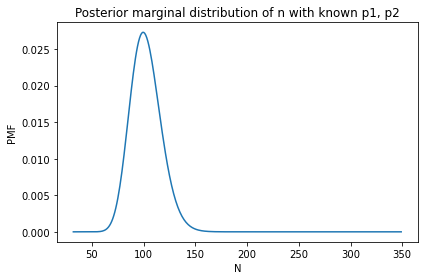

In [106]:
posterior_N.plot()

decorate(xlabel='Number of bugs (N)',
         ylabel='PMF',
         title='Posterior marginal distribution of n with known p1, p2')

With the assumption that `p0` and `p1` are known to be `0.2` and `0.15`, the posterior mean is 102 with 90% credible interval (79, 128).

In [52]:
posterior_N.mean(), posterior_N.credible_interval(0.9)

(81.13829780687273, array([ 34., 124.]))

But this result is based on the assumption that we know the probabilities, and we don't.

## Three-parameter model

What we need is a model with three parameters: `N`, `p0`, and `p1`.
Here are the priors:

In [53]:
prior_N = discrete_uniform(32, 350, name='N')
prior_N.shape

(318,)

In [54]:
prior_p0 = make_uniform(0, 1, num=51, name='p0')
prior_p1 = make_uniform(0, 1, num=51, name='p1')

prior_p0.head(3)

p0
0.00    0.019608
0.02    0.019608
0.04    0.019608
dtype: float64

Now we have to assemble them into a joint prior with three dimensions.
I'll start by putting the first two into a `DataFrame`.

In [55]:
joint2 = make_joint(prior_p0, prior_N)
joint2.shape

(318, 51)

Now I'll stack them, as in the previous example, and put the result in a `Pmf`.

In [56]:
joint2_pmf = Pmf(joint2.stack())
joint2_pmf.head(3)

N   p0  
32  0.00    0.000062
    0.02    0.000062
    0.04    0.000062
dtype: float64

We can use `make_joint` again to add in the third parameter.

In [57]:
joint3 = make_joint(prior_p1, joint2_pmf)
joint3.shape

(16218, 51)

The result is a `DataFrame` with values of `N` and `p0` in a `MultiIndex` that goes down the rows and values of `p1` in an index that goes across the columns.

In [58]:
joint3.head(3)

p1           0.00      0.02      0.04      0.06      0.08      0.10      0.12  \
N  p0                                                                           
32 0.00  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
   0.02  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   
   0.04  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001   

p1           0.14      0.16      0.18  ...      0.82      0.84      0.86  \
N  p0                                  ...                                 
32 0.00  0.000001  0.000001  0.000001  ...  0.000001  0.000001  0.000001   
   0.02  0.000001  0.000001  0.000001  ...  0.000001  0.000001  0.000001   
   0.04  0.000001  0.000001  0.000001  ...  0.000001  0.000001  0.000001   

p1           0.88      0.90      0.92      0.94      0.96      0.98      1.00  
N  p0                                                                          
32 0.00  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  
   0.02  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  
   0.04  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  0.000001  

[3 rows x 51 columns]

Now I'll apply `stack` again:

In [59]:
joint3_pmf = Pmf(joint3.stack())
joint3_pmf.head(3)

N   p0   p1  
32  0.0  0.00    0.000001
         0.02    0.000001
         0.04    0.000001
dtype: float64

The result is a `Pmf` with a three-column `MultiIndex` containing all possible triplets of parameters.

The number of rows is the product of the number of values in all three priors, which is almost 170,000.

In [60]:
joint3_pmf.shape

(827118,)

That's still small enough to be practical, but it will take longer to compute the likelihoods than in the previous examples.

Here's the loop that computes the likelihoods; it's similar to the one in the previous section:

In [61]:
likelihood = joint3_pmf.copy()
observed = data.sum()
x = data.copy()

for N, p0, p1 in joint3_pmf.index:
    x[0] = N - observed
    y = compute_probs(p0, p1)
    likelihood[N, p0, p1] = multinomial.pmf(x, N, y)

We can compute the posterior in the usual way.

In [62]:
posterior_pmf = joint3_pmf * likelihood
posterior_pmf.normalize()

8.99730066972982e-06

Now, to extract the marginal distributions, we could unstack the joint posterior as we did in the previous section.
But an alternative is to select "levels" from the `MultiIndex`.
The following is a version of `marginal` that works with a `Pmf` rather than a `DataFrame`:

In [63]:
def pmf_marginal(joint_pmf, level):
    """Compute a marginal distribution.
    
    joint_pmf: Pmf representing a joint distribution
    level: int, level to sum along
    
    returns: Pmf
    """
    return Pmf(joint_pmf.sum(level=level))

Here's the posterior distribution for `N`.

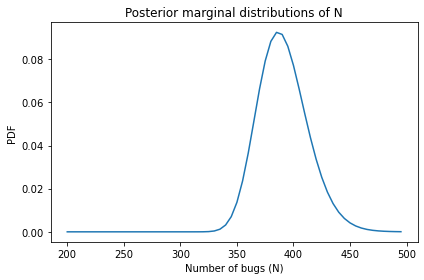

In [107]:
posterior_N = pmf_marginal(posterior_pmf, 0)
posterior_N.plot()

decorate(xlabel='Number of bugs (N)',
         ylabel='PDF',
         title='Posterior marginal distributions of N')

In [65]:
posterior_N.mean()

105.76546343172228

The posterior mean is 105 bugs, which suggests that there are still many bugs the testers have not found.

And here are the posteriors for `p0` and `p1`.

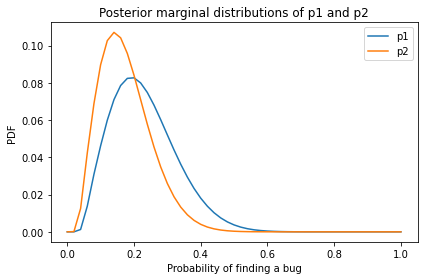

In [66]:
posterior_p1 = pmf_marginal(posterior_pmf, 1)
posterior_p2 = pmf_marginal(posterior_pmf, 2)

posterior_p1.plot(label='p1')
posterior_p2.plot(label='p2')
decorate(xlabel='Probability of finding a bug',
         ylabel='PDF',
         title='Posterior marginal distributions of p1 and p2')

In [67]:
posterior_p1.mean(), posterior_p1.credible_interval(0.9)

(0.22970639448042723, array([0.1, 0.4]))

In [68]:
posterior_p2.mean(), posterior_p2.credible_interval(0.9)

(0.17501156898201536, array([0.06, 0.32]))

Comparing the posterior distributions, the tester who found more bugs probably has a higher probability of finding bugs.  The posterior means are about 23% and 18%.  But the distributions overlap, so we should not be too sure.

This is the first example we've seen with three parameters.
As the number of parameters increases, the number of combinations increases quickly.
The method we've been using so far, enumerating all possible combinations, becomes impractical if the number of parameters is more than 3 or 4.

However there are other methods that can handle models with many more parameters, as we'll see in Chapter xxx.

## Summary

The problems in this chapter are examples of "[mark and recapture](https://en.wikipedia.org/wiki/Mark_and_recapture)" experiments, which are used in ecology to estimate animal populations.  They also have applications in engineering, as in the Lincoln index problem.  And in the exercises you'll see that they are used in epidemiology, too.

This chapter introduces two new probability distributions:

* The multinomial distribution is a generalization of the binomial distribution where there are more than two possible outcomes.

* The hypergeometric distribution is a variation of the binomial distribution in which samples are drawn from the population without replacement. 

Also in this chapter, we saw the first example of a model with three parameters.  We'll see more in subsequent chapters.

## Exercises

**Exercise:** [In an excellent paper](http://chao.stat.nthu.edu.tw/wordpress/paper/110.pdf), Anne Chao explains how mark and recapture experiments are used in epidemiology to estimate the prevalence of a disease in a human population based on multiple incomplete lists of cases.

One of the examples in that paper is a study "to estimate the number of people who were infected by hepatitis in an outbreak that occurred in and around a college in northern Taiwan from April to July 1995."

Three lists of cases were available:

1. 135 cases identified using a serum test. 

2. 122 cases reported by local hospitals. 

3. 126 cases reported on questionnaires collected by epidemiologists.

In this exercise, we'll use only the first two lists; in the next exercise we'll bring in the third list.

The following array contains 0 as a place-holder for the unknown value of `k00`, followed by known values of `k01`, `k10`, and `k11`. 

In [69]:
data2 = np.array([0, 73, 86, 49])

These data indicate that there are 73 cases on the second list that are not on the first, 86 cases on the first list that are not on the second, and 49 cases on both lists.

To keep things simple, we'll assume that each case has the same probability of appearing on each list.  So we'll use a two-parameter model where `N` is the total number of cases and `p` is the probability that any case appears on any list.

Here are priors you can start with (but feel free to modify them).

In [70]:
prior_N = discrete_uniform(200, 500, step=5, name='N')
prior_N.head(3)

N
200    0.016667
205    0.016667
210    0.016667
dtype: float64

In [71]:
prior_p = make_uniform(0, 0.98, num=50, name='p')
prior_p.head(3)

p
0.00    0.02
0.02    0.02
0.04    0.02
dtype: float64

Make a joint prior and update it using this data, then compute the posterior mean of `N` and a 90% credible interval.

In [72]:
# Solution

joint_prior = make_joint(prior_p, prior_N)
joint_prior.head(3)

p,0.00,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,...,0.80,0.82,0.84,0.86,0.88,0.90,0.92,0.94,0.96,0.98
N,,,,,,,,,,,,,,,,,,,,,
200,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,...,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333
205,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,...,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333
210,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,...,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333,0.000333


In [73]:
# Solution

prior_pmf = Pmf(joint_prior.stack())
prior_pmf.head(3)

N    p   
200  0.00    0.000333
     0.02    0.000333
     0.04    0.000333
dtype: float64

In [74]:
# Solution

observed = data2.sum()
x = data2.copy()
likelihood = prior_pmf.copy()

for N, p in prior_pmf.index:
    x[0] = N - observed
    q = 1-p
    y = [q*q, q*p, p*q, p*p]
    likelihood.loc[N, p] = multinomial.pmf(x, N, y)

In [75]:
# Solution

posterior_pmf = prior_pmf * likelihood
posterior_pmf.normalize()

1.266226682238907e-06

In [76]:
# Solution

joint_posterior = posterior_pmf.unstack()

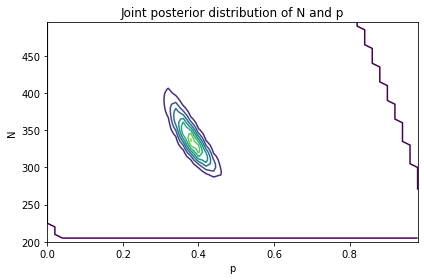

In [77]:
# Solution

plot_contour(joint_posterior)

decorate(title='Joint posterior distribution of N and p')

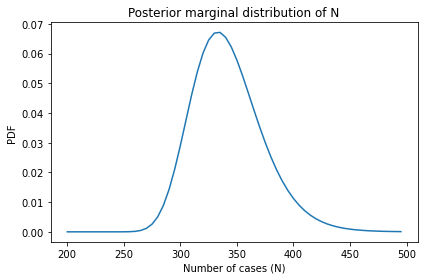

In [78]:
# Solution

marginal_N = marginal(joint_posterior, 1)
marginal_N.plot()

decorate(xlabel='Number of cases (N)',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

In [79]:
# Solution

marginal_N.mean(), marginal_N.credible_interval(0.9)

(342.1317040018937, array([295., 400.]))

**Exercise:** Now let's do the version of the problem with all three lists.  Here's the data from Chou's paper:

```
Hepatitis A virus list
P    Q    E    Data
1    1    1    k111 =28
1    1    0    k110 =21
1    0    1    k101 =17
1    0    0    k100 =69
0    1    1    k011 =18
0    1    0    k010 =55
0    0    1    k001 =63
0    0    0    k000 =??
```

And here it is in a NumPy array (in reverse order).

In [80]:
data3 = np.array([0, 63, 55, 18, 69, 17, 21, 28])

Again, the first value is a place-keeper for the unknown `k000`.  The second value is `k001`, which means there are 63 cases that appear on the third list but not the first two.  And the last value is `k111`, which means there are 28 cases that appear on all three lists.

In the two-list version of the problem we computed `ps` by enumerating the combinations of `p` and `q`.

In [81]:
q = 1-p
ps = [q*q, q*p, p*q, p*p]

We could do the same thing for the three-list version, computing the probability for each of the eight categories.  But we can generalize it by recognizing that we are computing the cartesian product of `p` and `q`, repeated once for each list.

And we can use the following function (based on [this StackOverflow answer](https://stackoverflow.com/questions/58242078/cartesian-product-of-arbitrary-lists-in-pandas/58242079#58242079)) to compute Cartesian products:

In [82]:
def cartesian_product(*args, **options):
    """Cartesian product of sequences.
    
    args: any number of sequences
    options: passes to `MultiIndex.from_product`
    
    returns: DataFrame with one column per sequence
    """
    index = pd.MultiIndex.from_product(args, **options)
    return pd.DataFrame(index=index).reset_index()

Here's an example with `p=0.2`:

In [83]:
p = 0.2
t = (1-p, p)
df = cartesian_product(t, t, t)
df

,level_0,level_1,level_2
0,0.8,0.8,0.8
1,0.8,0.8,0.2
2,0.8,0.2,0.8
3,0.8,0.2,0.2
4,0.2,0.8,0.8
5,0.2,0.8,0.2
6,0.2,0.2,0.8
7,0.2,0.2,0.2


To compute the probability for each category, we take the product across the columns:

In [84]:
y = df.prod(axis=1)
y

0    0.512
1    0.128
2    0.128
3    0.032
4    0.128
5    0.032
6    0.032
7    0.008
dtype: float64

Write a loop that computes the likelihood of the data for each pair of parameters, then update the prior and compute the posterior mean of `N`.  How does it compare to the results using on the first two lists?

In [85]:
# Solution

observed = data3.sum()
x = data3.copy()
likelihood = prior_pmf.copy()

for N, p in prior_pmf.index:
    x[0] = N - observed
    t = (1-p, p)
    df = cartesian_product(t, t, t)
    y = df.prod(axis=1)
    likelihood.loc[N, p] = multinomial.pmf(x, N, y)

In [86]:
# Solution

posterior_pmf = prior_pmf * likelihood
posterior_pmf.normalize()

2.6359517829553705e-16

In [87]:
# Solution

joint_posterior = posterior_pmf.unstack()

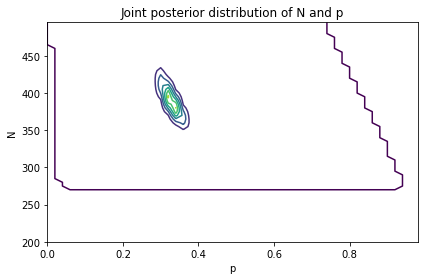

In [88]:
# Solution

plot_contour(joint_posterior)

decorate(title='Joint posterior distribution of N and p')

In [89]:
# Solution

marginal3_N = marginal(joint_posterior, 1)

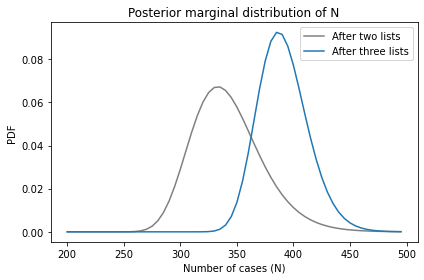

In [90]:
# Solution

marginal_N.plot(color='gray', label='After two lists')
marginal3_N.plot(label='After three lists')

decorate(xlabel='Number of cases (N)',
         ylabel='PDF',
         title='Posterior marginal distribution of N')

In [91]:
# Solution

marginal_N.mean(), marginal_N.credible_interval(0.9)

(342.1317040018937, array([295., 400.]))

In [92]:
# Solution

marginal3_N.mean(), marginal3_N.credible_interval(0.9)

(391.0050140750373, array([360., 430.]))